<a href="https://colab.research.google.com/github/vaghyjuli/RL/blob/main/lunar_q_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://arxiv.org/pdf/2011.11850.pdf

In [ ]:
%%bash

# install required system dependencies
apt-get install -y xvfb x11-utils

# install required python dependencies (might need to install additional gym extras depending)
pip install gym[box2d]==0.17.* pyvirtualdisplay==0.2.* PyOpenGL==3.1.* PyOpenGL-accelerate==3.1.*

Reading package lists...
Building dependency tree...
Reading state information...
x11-utils is already the newest version (7.7+3build1).
xvfb is already the newest version (2:1.19.6-1ubuntu4.10).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.


In [ ]:
import pyvirtualdisplay

_display = pyvirtualdisplay.Display(visible=False,  # use False with Xvfb
                                    size=(1400, 900))
_ = _display.start()

In [ ]:
import gym
import numpy as np
import pandas as pd
import random

## Action space
Discrete(4) \\
[0] - do nothing \\
[1] - fire left orientation engine \\
[2] - fire right orientation engine \\
[3] - fire main engine

## Observation space
Box(-inf, inf, (8,), float32) \\
Low = [-inf -inf -inf -inf -inf -inf -inf -inf] \\
High = [inf inf inf inf inf inf inf inf]

Each observation contains 8 values: \\
(Continuous): X distance from target site \\
(Continuous): Y distance from target site \\
(Continuous): X velocity \\
(Continuous): Y velocity \\
(Continuous): Angle of ship \\
(Continuous): Angular velocity of ship \\
(Binary): Left leg is grounded \\
(Binary): Right leg is grounded

In [ ]:
class Agent():

  def __init__(self, n_actions):
    self.gamma = 0.8                                # discount
    self.epsilon = 0.3                              # exploration

    self.num_bins = 10                              # number of bins for discretizing continuous state variables
    self.bins2D = []                                # num_bins bins for each of the 6 continuous variables
    self.init_bins()

    self.n_actions = n_actions                      # number of actions
    self.dim_state = (self.num_bins ** 6) * (2 ** 2)          # 6 continuous, 2 binary
    self.Q = np.zeros((self.dim_state, n_actions))       # initialize Q(s,a) table

  def get_action(self, state):
    if random.uniform(0, 1) < self.epsilon:
      return np.random.choice(range(self.n_actions))
    else:
      return np.argmax(self.Q[self.get_state_index(state)])

  def q_update(self, prev_state, action, reward, new_state, alpha):
    prev_state_idx = self.get_state_index(prev_state)
    new_state_idx = self.get_state_index(new_state)
    self.Q[prev_state_idx][action] += alpha * (reward + self.gamma * np.max(self.Q[new_state_idx]) - self.Q[prev_state_idx][action])

  def init_bins(self):
    state_min = [-1.01975346, -0.44636688, -2.29403067, -2.22342443, -4.9213028, -8.83636475]
    state_max = [1.0239284, 1.8099494, 2.47327113, 0.62224495, 4.42566919, 8.98535538]
    for i in range(6):
      step = (state_max[i] - state_min[i]) / self.num_bins
      left_bounds = [(state_min[i] + step * j) for j in range(self.num_bins)]
      right_bounds = [(state_min[i] + step * (j+1)) for j in range(self.num_bins)]
      # chance of going outside this range is small but better be safe, so:
      left_bounds[0] = -float("inf")
      right_bounds[-1] = float("inf")
      self.bins2D.append(pd.IntervalIndex.from_arrays(left_bounds, right_bounds, closed="neither"))
    print(self.bins2D)

  def get_state_representation(self, state):
    representation = [self.bins2D[i].get_loc(state[i]) for i in range(6)]
    representation.append(int(state[6]))
    representation.append(int(state[7]))
    return representation

  def get_state_index(self, state):
    num = 0
    for i in range(5):
      num = (num + bins2D[i].get_loc(state[i]))*self.num_bins
    num = ((num + bins2D[5].get_loc(state[5]))*2 + int(state[-2]))*2 + int(state[-1])
    return num

  def get_Qs(self, state):
    return self.Q[self.get_state_index(state)]

  def measure_learning(self):
    return np.count_nonzero(self.Q) / (self.dim_state * 4)

In [ ]:
n_episodes = 1

env = gym.make('LunarLander-v2')
agent = Agent(env.action_space.n)

cum_rewards = []
for episode in range(n_episodes):
    state = env.reset()
    t = 0
    cum_reward = 0
    while True:
      #env.render()
      prev_state = state
      prev_state_idx = agent.get_state_index(prev_state)
      action = agent.get_action(state)
      state, reward, done, info = env.step(action)
      cum_reward += reward
      #print(f"Old Q({prev_state_idx},_) = {agent.get_Qs(prev_state)}")
      alpha = (n_episodes - episode) / n_episodes
      agent.q_update(prev_state, action, reward, state, alpha)
      state_idx = agent.get_state_index(state)
      #print(f"State {prev_state_idx} \n+ Action {action} \n-> State {state_idx}\nReward = {reward}")
      #print(f"New Q({prev_state_idx},_) = {agent.get_Qs(prev_state)}\n\n")
      if done:
          print(f"Episode {episode+1}. {t+1} timesteps, cum_reward = {cum_reward} \n")
          break
      t += 1
    cum_rewards.append(cum_reward)

print(agent.measure_learning())
env.close()

[IntervalIndex([(-inf, -0.815385274), (-0.815385274, -0.611017088), (-0.611017088, -0.4066489019999999), (-0.4066489019999999, -0.20228071599999997), (-0.20228071599999997, 0.00208746999999998), (0.00208746999999998, 0.20645565600000015), (0.20645565600000015, 0.4108238420000001), (0.4108238420000001, 0.6151920280000001), (0.6151920280000001, 0.819560214), (0.819560214, inf)],
              closed='neither',
              dtype='interval[float64]'), IntervalIndex([(-inf, -0.22073525200000002), (-0.22073525200000002, 0.00489637599999998), (0.00489637599999998, 0.23052800399999995), (0.23052800399999995, 0.456159632), (0.456159632, 0.68179126), (0.68179126, 0.9074228879999999), (0.9074228879999999, 1.133054516), (1.133054516, 1.358686144), (1.358686144, 1.5843177720000001), (1.5843177720000001, inf)],
              closed='neither',
              dtype='interval[float64]'), IntervalIndex([(-inf, -1.81730049), (-1.81730049, -1.3405703100000002), (-1.3405703100000002, -0.8638401300000003),

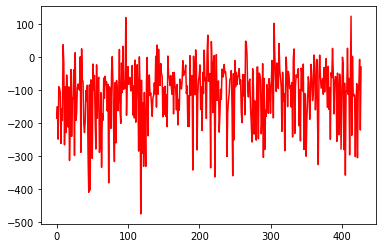

In [ ]:
import matplotlib.pyplot as plt

plt.plot(cum_rewards, color="red")

plt.show()